# Plot latent space of scDeepCluster

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import umap
import scanpy as sc
from collections import OrderedDict
from sklearn.cluster import KMeans

sc.logging.print_version_and_date()
sns.set(style='white', context='notebook', rc={'figure.figsize': (9, 5)})
np.random.seed(42)

Running Scanpy 1.5.1, on 2020-07-21 02:39.


Load the preprocessed data, the latent embedding from scDeepCluster (bottleneck) and the annotations file from cellassign:

In [2]:
label2num = {
    'Neural progenitors': 1,
    'Intermediate progenitors': 2,
    'Post-mitotic neurons': 3,
    'Ectopic cells': 4
}

num2label = {v: k for k, v in label2num.items()}  # reverse mapping

In [3]:
def get_all_data(dataset_name):
    data = sc.read_h5ad('../ann_data/exp_04/' + dataset_name + '_norm_variable_genes.h5ad')
    labels = pd.read_csv('../ann_data/exp_04/annotations/' + dataset_name + '_cellassign.csv')
    bottleneck = pd.read_csv('./exp_04/variable_genes/' + dataset_name + '_latent_output.csv', header=None)

    # Add cell type annotations to the original data object
    data.obs['cell_type'] = labels['cell_type'].tolist()
    data.obs['cell_type_num'] = labels['cell_type'].map(label2num).tolist()

    return data, labels, bottleneck

In [4]:
def count_cell_types(labels):
    for ct in set(labels['cell_type']):
        print(ct, len(labels[labels['cell_type'] == ct]))

Load datasets after being preprocessed:

In [5]:
E13, E13_labels, E13_bottleneck = get_all_data('E13_hom')
E14, E14_labels, E14_bottleneck = get_all_data('E14_hom')

In [6]:
print('E13_HOM cell types:')
count_cell_types(E13_labels)
print('\nE14_HOM cell types:')
count_cell_types(E14_labels)

E13_HOM cell types:
Post-mitotic neurons 1276
Ectopic cells 15
Neural progenitors 4461
Intermediate progenitors 470

E14_HOM cell types:
Ectopic cells 1566
Post-mitotic neurons 1553
Neural progenitors 889
Intermediate progenitors 255


In [7]:
marker_genes = dict()
marker_genes['neural_progen'] = ['Pax6', 'Vim', 'Sox2']
# marker_genes['neural_progen'] = ['Pax6', 'Sox2']
marker_genes['intermediate_progen'] = ['Eomes', 'Btg2']
marker_genes['post_mitotic'] = ['Tbr1', 'Sox5']
marker_genes['ectopic'] = ['Gsx2', 'Prdm13', 'Dlx1', 'Dlx2', 'Dlx5', 'Gad1', 'Gad2', 'Ptf1a', 'Msx3', 'Helt', 'Olig3']

main_cell_types = marker_genes['neural_progen'] + marker_genes['intermediate_progen'] + marker_genes['post_mitotic']

Functions to run and plot UMAP:

In [8]:
def fit_umap(data, n_neighbors=5, min_dist=0.8, n_components=2, metric='euclidean'):
    np.random.seed(42)
    umap_fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    embedding = umap_fit.fit_transform(data)
    return embedding    

In [9]:
def draw_umap(data, labels,embedding=None, n_neighbors=5, min_dist=0.99, n_components=2,
              metric='euclidean', title='', cmap='tab10', legend_title='Cell type'):
    
    np.random.seed(42)
    if embedding is not None:
        u = embedding
    else:
        u = fit_umap(data, n_neighbors, min_dist)
    
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(u[:,0], range(len(u)), c=labels, cmap=cmap, marker='.')
    if n_components == 2:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(u[:,0], u[:,1], c=labels or None, cmap=cmap, marker='.')
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(u[:,0], u[:,1], u[:,2], c=labels, s=100, cmap=cmap, marker='.')
    
    legend1 = ax.legend(*scatter.legend_elements(), title=legend_title)
    ax.add_artist(legend1)
    plt.title(title, fontsize=18)

In [10]:
def plot_umap_for_markers(embedding, orig_data, labels, n_neighbors=5, min_dist=0.8, n_components=2,
                          metric='euclidean', title='', cmap='tab10', show_legend=True):

    len_labels = len(labels)
    fig_size = (15, 30) if len_labels < 10 else (15, 45)
    fig = plt.figure(figsize=fig_size)
    
    # Create subplots
    subplot_idx = 1
    for label in labels:
        if label in orig_data.var_names:
            ax = fig.add_subplot(len_labels, 3, subplot_idx)
            scatter = ax.scatter(embedding[:,0], embedding[:,1], c=orig_data[:, label].X, cmap=cmap, marker='.')
            plt.title(label, fontsize=15)
            subplot_idx = subplot_idx + 1

Followed this tutorial: https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb

In [11]:
def cell_cycle_phase(adata, min_dist=0.1):
    # Get cell cycle scores and phases from the initial dataset and use the phases to plot the latent space
    
    # Load initial dataset (after qc and pre-normalisation - the one we feed to the AE) and the list
    # of predefined cell cycle genes
    print('Initial dataset', adata.shape)
    cell_cycle_genes = [x.strip().lower().capitalize() for x in open('../preprocessing/regev_lab_cell_cycle_genes.txt')]

    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]
    cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
    cc_phase = adata.obs.phase

    adata_cc_genes = adata[:, cell_cycle_genes]
    
    # Check if cells are separated by their cell cycle phase when cell cycle genes are used
    mapping = {'G1': 1, 'S': 2, 'G2M': 3}
    cc_phase_num = [mapping[i] for i in list(cc_phase)]
    draw_umap(adata_cc_genes.X,  cc_phase_num, legend_title='Cell cycle phase',
              title='Initial dataset', min_dist=min_dist)


    # Strong effect of cell cycle effect -> unwanted variation -> regress out
    sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
    sc.pp.scale(adata)

    # Replot umap withe cell cycle genes to check that the phase has been regressed out
    adata_cc_genes = adata[:, cell_cycle_genes]
    # sc.tl.pca(adata_cc_genes)
    # sc.pl.pca_scatter(adata_cc_genes, color='phase')
    draw_umap(adata_cc_genes.X,  cc_phase_num, legend_title='Cell cycle phase',
              title='After regressing out the phase', min_dist=min_dist)
    
    
    return cc_phase_num

## E13_HOM dataset

### Initial dataset:

... storing 'cell_type' as categorical
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* arg

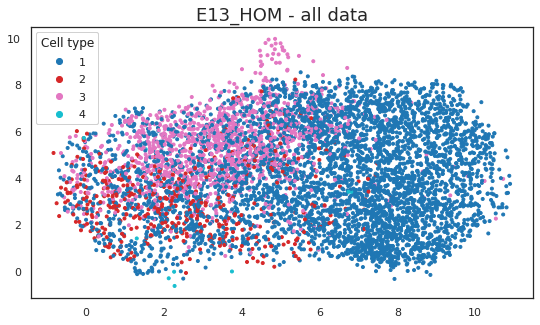

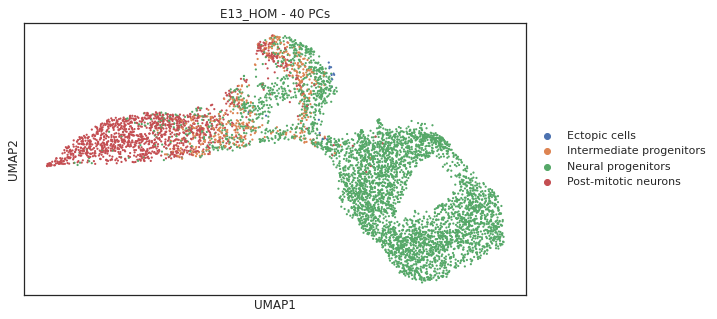

In [12]:
E13_annotations = E13.obs['cell_type_num'].tolist()
E13_embedding = fit_umap(E13.X)

# UMAP on the whole dataset X
draw_umap(E13.X, E13_annotations, embedding=E13_embedding, n_neighbors=15,
          min_dist=0.1, title='E13_HOM - all data')

# UMAP on the first 40 PCs
sc.pl.umap(E13, color='cell_type', title='E13_HOM - 40 PCs')

### Latent space of the autoencoder (scDeepCluster)

#### Clustering with K-Means on the latent space:

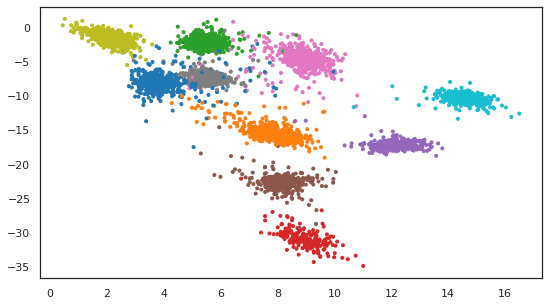

In [63]:
kmeans_pred = KMeans(n_clusters=10, random_state=42).fit(E13_bottleneck)
plt.scatter(E13_bottleneck.loc[:, 0], E13_bottleneck.loc[:, 1],
            c=kmeans_pred.labels_, cmap='tab10', marker='.')

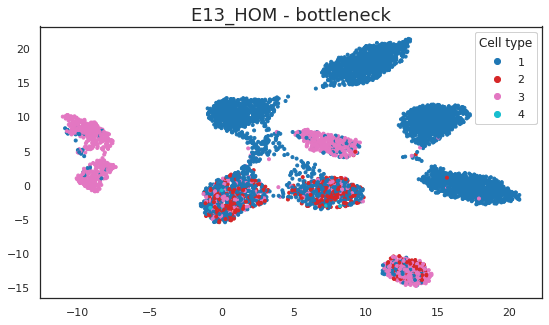

In [53]:
E13_bottleneck_embedding = fit_umap(E13_bottleneck, n_neighbors=15, min_dist=0.7)
draw_umap(E13_bottleneck, E13_annotations, embedding=E13_bottleneck_embedding,
          n_neighbors=15, min_dist=0.9, title='E13_HOM - bottleneck')

### Plot latent space using the gene markers for each cell type:

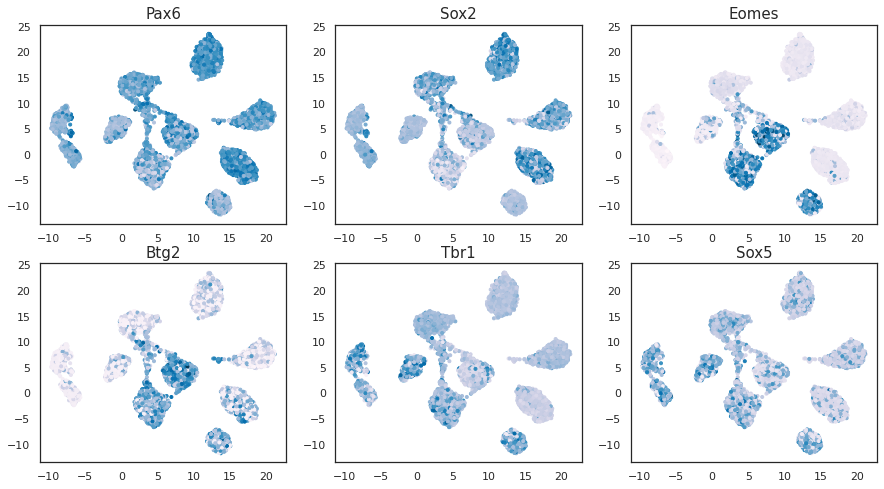

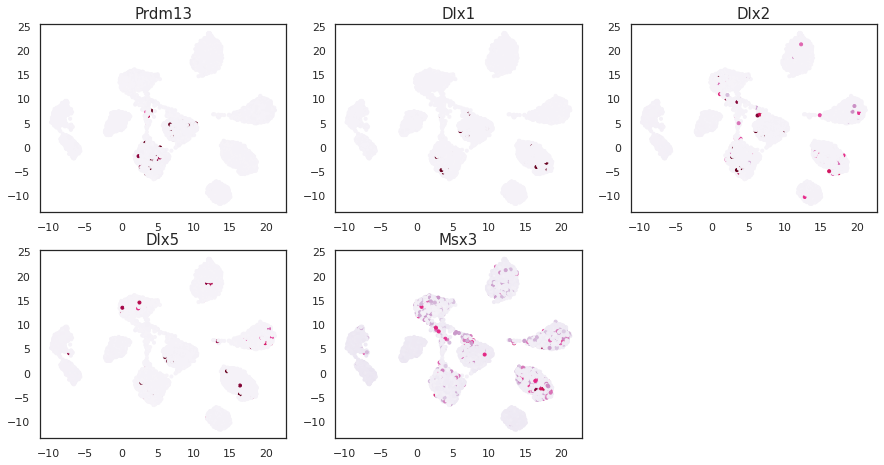

In [15]:
plot_umap_for_markers(E13_bottleneck_embedding, E13, main_cell_types, cmap='PuBu')
plot_umap_for_markers(E13_bottleneck_embedding, E13, marker_genes['ectopic'], cmap='PuRd')

### Check cell cycle phase

Plot UMAP for the initial dataset using the cell cycle phases:

Initial dataset (6222, 1722)


... storing 'phase' as categorical


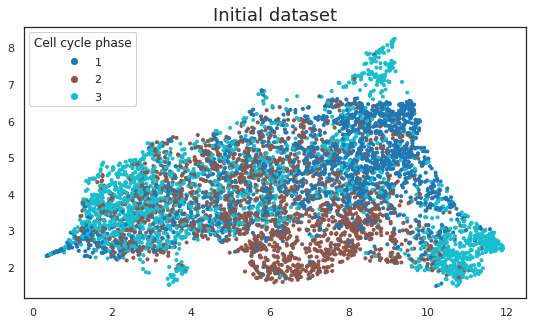

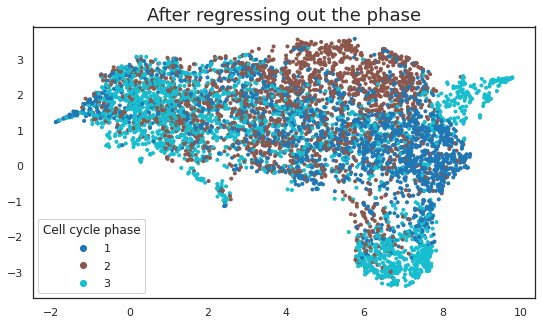

In [16]:
cell_cycle_phases_E13 = cell_cycle_phase(E13)

Plot UMAP for the latent space using the cell cycle phases:

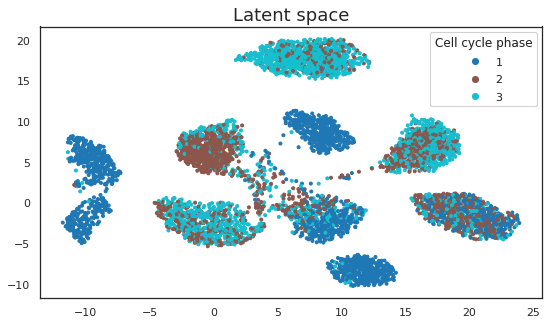

In [17]:
draw_umap(E13_bottleneck, cell_cycle_phases_E13, n_neighbors=15, min_dist=0.9, legend_title='Cell cycle phase', title='Latent space')

## E14_HOM  dataset

### Initial dataset:

Umap on all data:

... storing 'cell_type' as categorical
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* arg

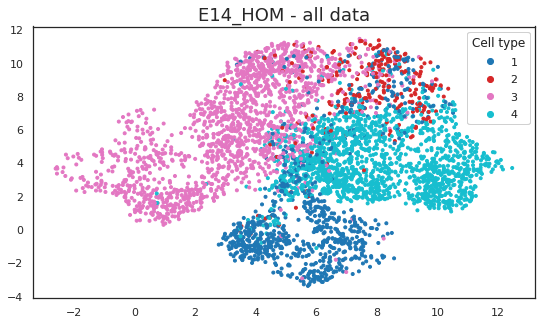

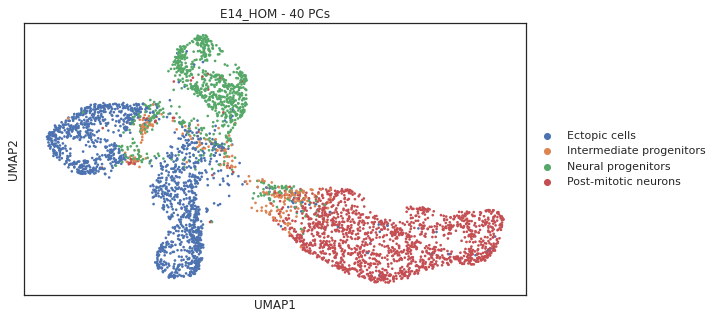

In [18]:
E14_annotations = E14.obs['cell_type_num'].tolist()
E14_embedding = fit_umap(E14.X)

# UMAP on the whole dataset X
draw_umap(E14.X, E14_annotations, embedding=E14_embedding, n_neighbors=15,
          min_dist=0.1, title='E14_HOM - all data')

# UMAP on the first 40 PCs
sc.pl.umap(E14, color='cell_type', title='E14_HOM - 40 PCs')

### Latent space of the autoencoder (scDeepCluster)

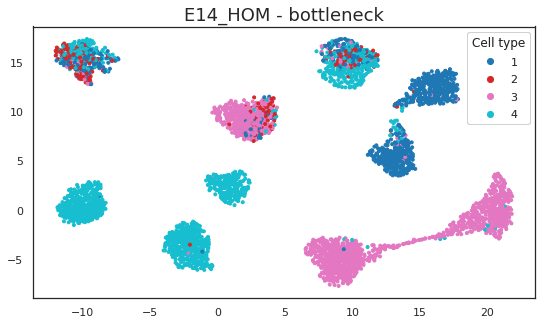

In [19]:
E14_bottleneck_embedding = fit_umap(E14_bottleneck, n_neighbors=15, min_dist=0.7)
draw_umap(E14_bottleneck, E14_annotations, embedding=E14_bottleneck_embedding,
          n_neighbors=15, min_dist=0.9, title='E14_HOM - bottleneck')

### Plot latent space using the gene markers for each cell type:

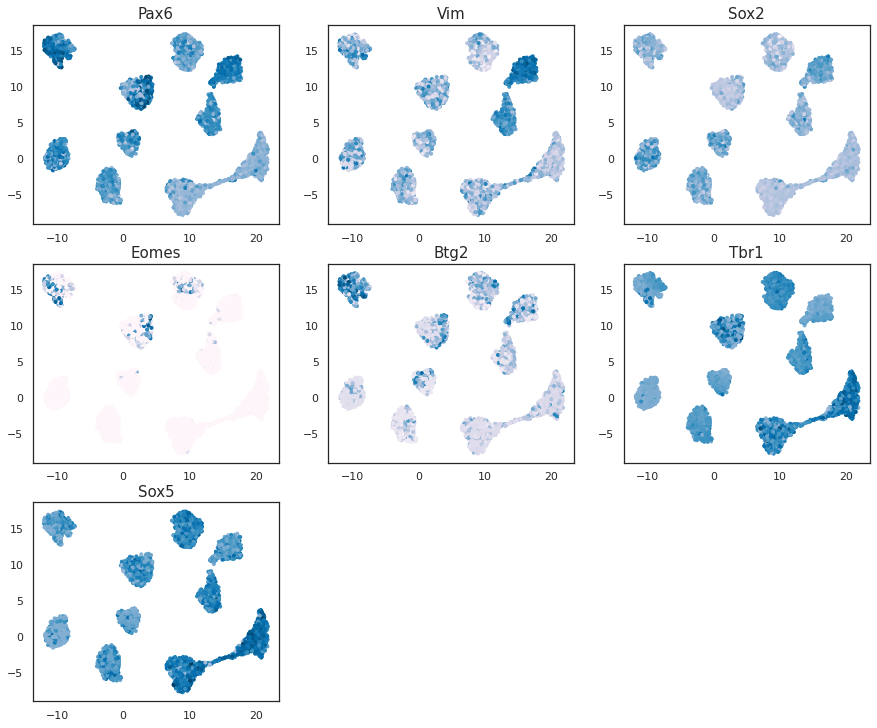

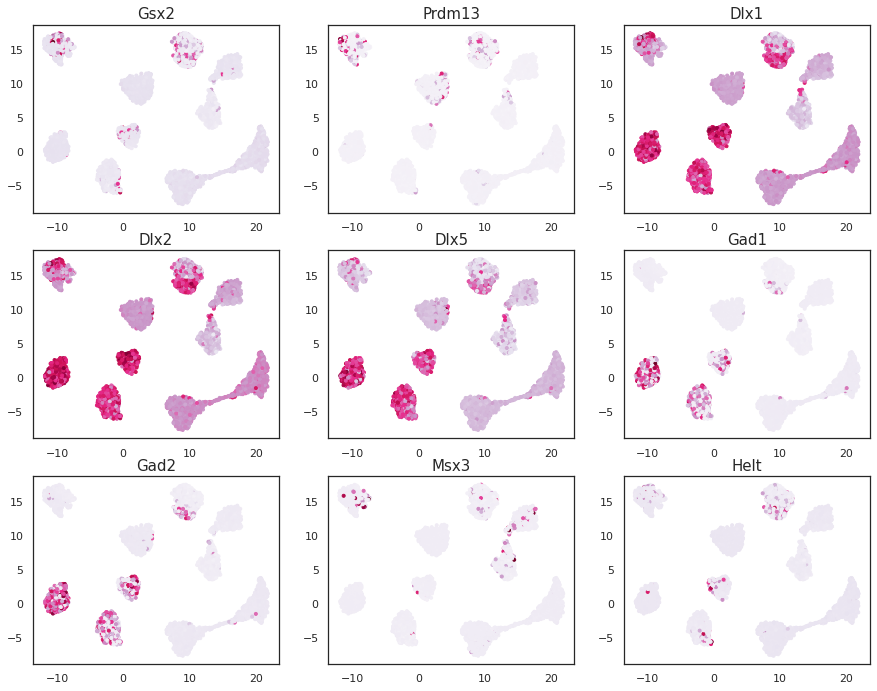

In [20]:
plot_umap_for_markers(E14_bottleneck_embedding, E14, main_cell_types, cmap='PuBu')
plot_umap_for_markers(E14_bottleneck_embedding, E14, marker_genes['ectopic'], cmap='PuRd')

### Check cell cycle phase

Plot UMAP for the initial dataset using the cell cycle phases:

Initial dataset (4263, 2410)


... storing 'phase' as categorical


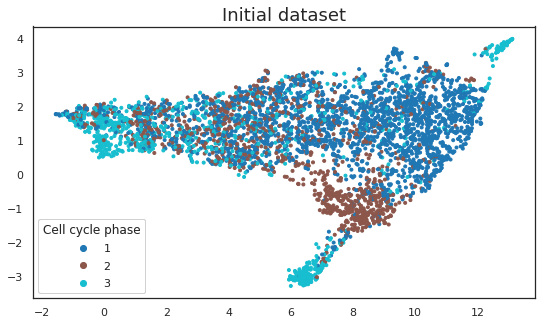

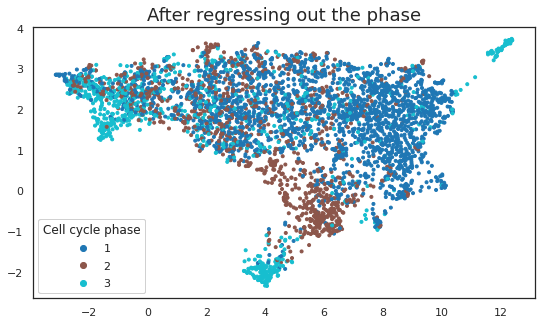

In [21]:
cell_cycle_phases_E14 = cell_cycle_phase(E14)

Plot UMAP for the latent space using the cell cycle phases:

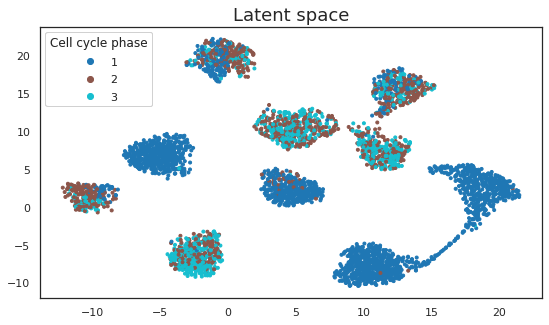

In [22]:
draw_umap(E14_bottleneck, cell_cycle_phases_E14, n_neighbors=15, min_dist=0.9, legend_title='Cell cycle phase', title='Latent space')